# Fraud Detection using CategoricalNB Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.preprocessing import LabelEncoder

# Define Functionality Across Datasets

In [2]:
def preprocess_data(filename):
    """
    Loads the dataset, converts numerical features to categorical using quartiles,
    drops the 'month' feature, and encodes categorical string features.
    
    Args:
        filename (str): Path to the dataset CSV file.
        
    Returns:
        pd.DataFrame: Preprocessed dataframe.
    """
    # Load dataset
    df = pd.read_csv(f"FinanceData/{filename}")
    
    # Drop 'month' column
    df.drop(columns=["month"], inplace=True)
    
    # Define binary classifiers to exclude from numerical columns
    binary_classifiers = [
        "fraud_bool", "email_is_free", "phone_home_valid", "phone_mobile_valid",
        "has_other_cards", "foreign_request", "keep_alive_session"
    ]
    
    # Identify numerical columns (excluding binary classifiers)
    numerical_cols = [col for col in df.select_dtypes(include='number').columns if col not in binary_classifiers]
    
    # Convert numerical features to categorical using quartiles
    def convert_to_quartiles(data, feature):
        q1 = data[feature].quantile(0.25)
        q2 = data[feature].quantile(0.50)
        q3 = data[feature].quantile(0.75)
        
        bins = [-float('inf'), q1, q2, q3, float('inf')]
        quartile_series = pd.cut(data[feature], bins=bins, labels=False, include_lowest=True, duplicates='drop')
        return quartile_series.astype(int)
    
    for col in numerical_cols:
        df[col] = convert_to_quartiles(df, col)
    
    # Encode categorical string features
    categorical_vars = ["payment_type", "employment_status", "housing_status", "source", "device_os"]
    le = LabelEncoder()
    
    for col in categorical_vars:
        df[col] = le.fit_transform(df[col])
    
    return df

In [3]:
def train_categorical_nb_kfold(df, k=5, test_size=0.25, alpha=1.0):
    """
    Trains a CategoricalNB model using k-fold cross-validation and returns performance metrics.
    
    Args:
        df (pd.DataFrame): Preprocessed dataframe.
        k (int): Number of folds for cross-validation.
        test_size (float): Proportion of data to use for the test set.
        alpha (float): Smoothing parameter for the CategoricalNB model.
        
    Returns:
        dict: A dictionary containing collected metrics and data for plotting.
    """
    # Split features and target
    X = df.drop("fraud_bool", axis=1)
    y = df["fraud_bool"]
    
    # Initialize the Naive Bayes classifier with alpha parameter
    nb = CategoricalNB(alpha=alpha)
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=5525)
    
    # Metrics storage
    # This will hold the average values across all K-folds
    all_metrics = {
        'accuracy': 0,
        'precision': 0,
        'f1_score': 0,
        'auc': 0,
        'recall': 0
    }

    # Temporary metrics storage for all k-folds
    temp_metrics = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        'auc': [],
        "recall": []
    }
    
    # For ROC Curves and Confusion Matrixes
    y_test_combined = []
    y_pred_combined = []
    y_pred_proba_combined = []
    
    # Perform K-Fold Cross Validation
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        nb.fit(X_train, y_train)
        
        # Predicr results
        y_pred = nb.predict(X_test)
        y_pred_proba = nb.predict_proba(X_test)[:, 1]
        
        # Store predictions for confusion matrix later
        y_test_combined.extend(y_test)
        y_pred_combined.extend(y_pred)
        y_pred_proba_combined.extend(y_pred_proba)
        
        # Compute and Store metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        recall = recall_score(y_test, y_pred)
        
        # Add computed metrics to storage dictionary
        temp_metrics['accuracy'].append(accuracy)
        temp_metrics['precision'].append(precision)
        temp_metrics['f1'].append(f1)
        temp_metrics['auc'].append(auc)
        temp_metrics['recall'].append(recall)
        
    # Update all metrics
    all_metrics = {
        'accuracy': np.mean(temp_metrics['accuracy']),
        'precision': np.mean(temp_metrics['precision']),
        'f1_score': np.mean(temp_metrics['f1']),
        'auc': np.mean(temp_metrics['auc']),
        'recall': np.mean(temp_metrics['recall'])
    }
        
    return all_metrics, y_test_combined, y_pred_combined, y_pred_proba_combined, nb.classes_

In [4]:
def train_categorical_nb(df, train_sizes=np.arange(0.05,1.0,0.05), alpha_pcts=np.arange(0.01, 0.21, 0.01), mode='train_size', constant_alpha=1.0, constant_train_size=0.75):
    results = {
        'train_size': [],
        'alpha': [],
        'accuracy': [],
        'precision': [],
        'f1_score': [],
        'recall': []
    }

    X = df.drop(columns='fraud_bool')
    y = df['fraud_bool']
    
    if mode == 'train_size':
        # Varying train sizes with a constant alpha
        for train_size in train_sizes:
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=5525)
            
            # Initialize and train the model with the constant alpha
            model = CategoricalNB(alpha=constant_alpha)
            model.fit(X_train, y_train)
            
            # Make predictions on the test set
            y_pred = model.predict(X_test)
            
            # Compute metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            # Store the results
            results['train_size'].append(train_size)
            results['alpha'].append(constant_alpha)
            results['accuracy'].append(accuracy)
            results['precision'].append(precision)
            results['f1_score'].append(f1)
            results['recall'].append(recall)
    
    elif mode == 'alpha':
        # Varying alphas with a constant train size
        for pct in alpha_pcts:
            # Split the data into training and testing sets with a constant train size
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=constant_train_size, random_state=5525)
            
            # Calculate alpha dynamically based on the number of positive cases in y_train
            alpha_val = pct * np.sum(y_train)
            
            # Initialize and train the model with the calculated alpha
            model = CategoricalNB(alpha=alpha_val)
            model.fit(X_train, y_train)
            
            # Make predictions on the test set
            y_pred = model.predict(X_test)
            
            # Compute metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            # Store the results
            results['train_size'].append(constant_train_size)
            results['alpha'].append(alpha_val)
            results['accuracy'].append(accuracy)
            results['precision'].append(precision)
            results['f1_score'].append(f1)
            results['recall'].append(recall)
    
    return results

In [5]:
def plot_results(metrics_list, labels):
    """
    Generates plots for confusion matrix and ROC curve based on collected metrics for multiple datasets.
    
    Args:
        metrics_list (list): List of dictionaries containing metrics from model training.
        labels (list): List of labels corresponding to each dataset.
    """
    # Plot ROC Curves for multiple datasets
    plt.figure(figsize=(10, 8))
    for metrics, label in zip(metrics_list, labels):
        fpr, tpr, _ = roc_curve(metrics["y_true"], metrics["y_pred_proba"])
        mean_auc = np.mean(metrics["roc_auc"])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {mean_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    
    # Plot Confusion Matrices for each dataset
    for metrics, label in zip(metrics_list, labels):
        disp = ConfusionMatrixDisplay(confusion_matrix=metrics["conf_matrix"], display_labels=[0, 1])
        disp.plot(cmap="Blues")
        plt.title(f"Aggregated Confusion Matrix - {label}")
        plt.show()


In [6]:
def plot_metric_grids(all_results, datasets, metric, x_param, x_lim=None, y_lim=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle(f'{metric} vs {x_param}', fontsize=22)
    axes = axes.ravel()
    
    # Loop through each dataset and subplot
    for i, dataset_name in enumerate(datasets):
        ax = axes[i]
        
        # Extract results for the current dataset
        dataset_results = all_results['results'][i]
        
        # Extract data for plotting
        x_values = np.array(dataset_results[x_param])
        y_values = np.array(dataset_results[metric])
        
        # Plot the data
        ax.plot(x_values, y_values, marker='o', linestyle='-')
        ax.set_title(dataset_name, fontsize=16)
        ax.set_xlabel(x_param, fontsize=14)
        ax.set_ylabel(metric, fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True)
        
        # Set limits on axes
        if x_lim:
            ax.set_xlim(x_lim)
        
        if y_lim:
            ax.set_ylim(y_lim)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [7]:
# Put all file names to test in a list
# This is all of the data sets we will test with CategoricalNB Classifier
data = ['Base.csv', 'Variant I.csv', 'Variant II.csv', 'Variant III.csv', 'Variant IV.csv', 'Variant V.csv']

# Initialize results list to store results for each variant dataframe
results_df = pd.DataFrame(columns=['dataset', 'accuracy', 'precision', 'f1_score', 'recall', 'auc'])

# Confusion Matrix and ROC Curve with AUC for All Models

Results for Base.csv


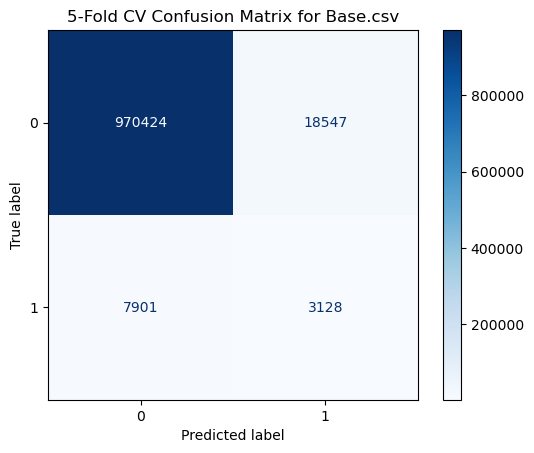

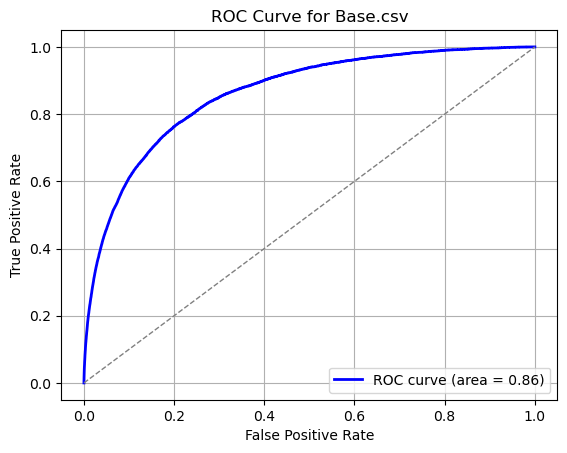

Results for Variant I.csv


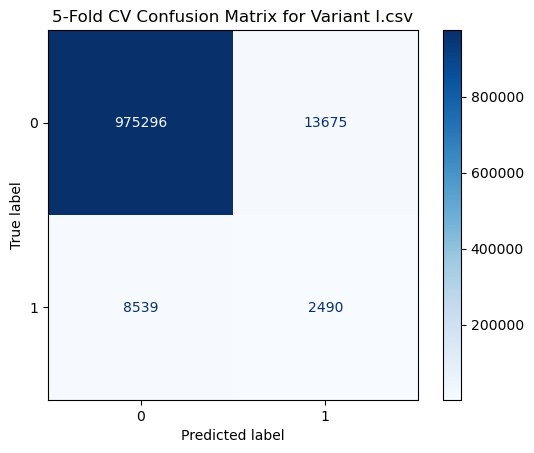

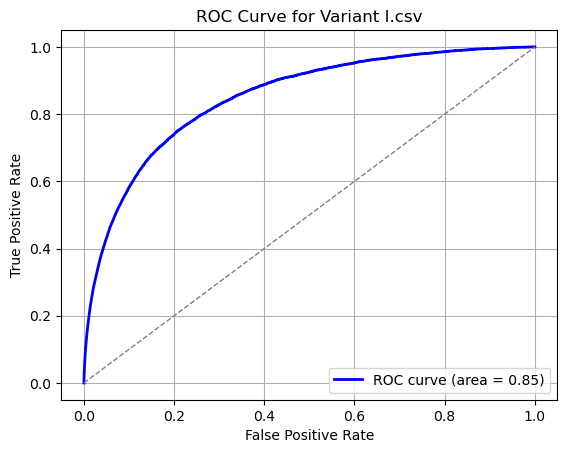

Results for Variant II.csv


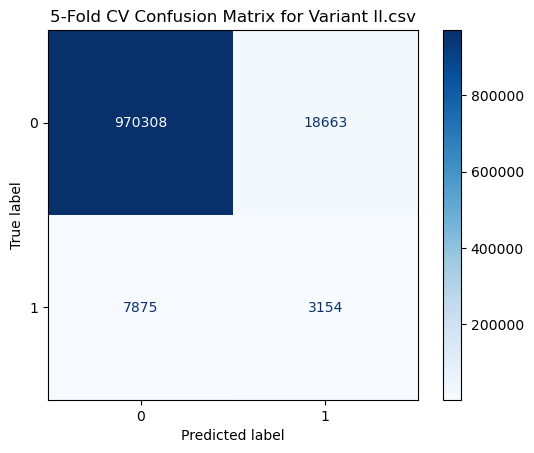

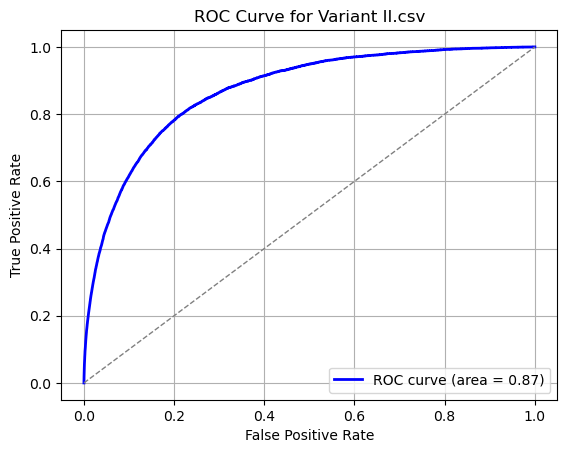

Results for Variant III.csv


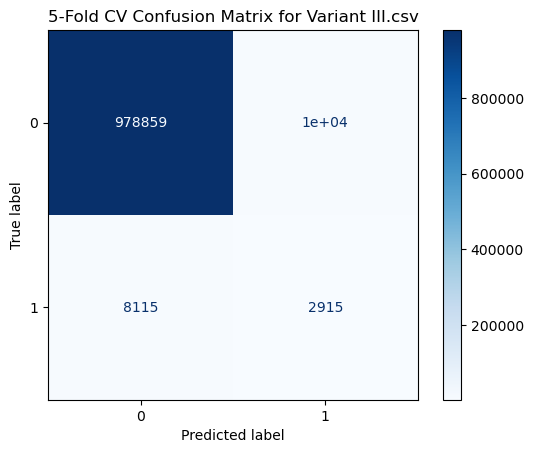

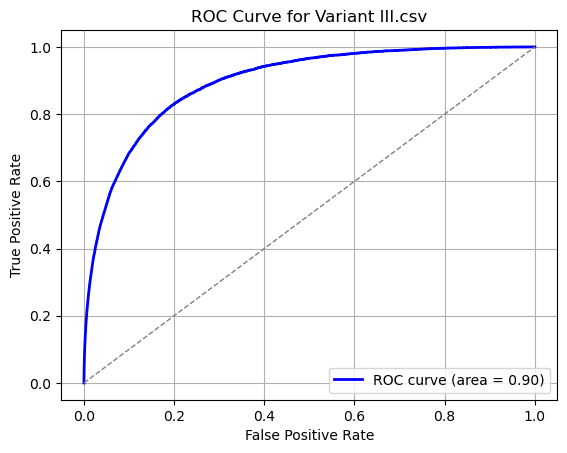

Results for Variant IV.csv


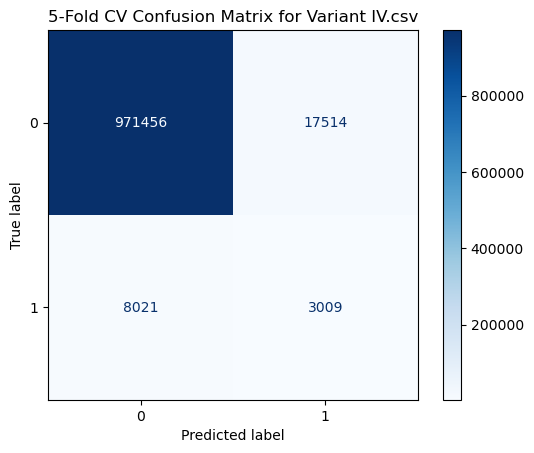

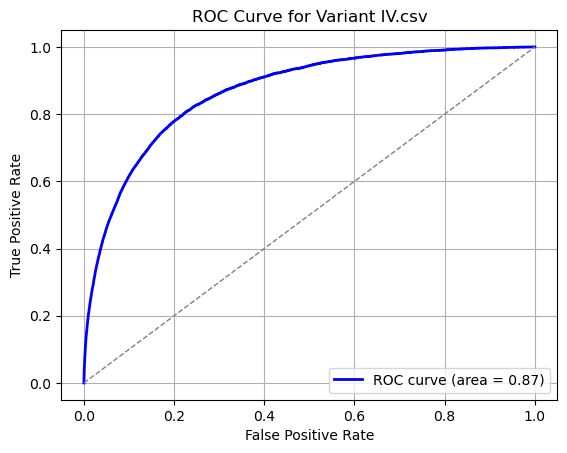

Results for Variant V.csv


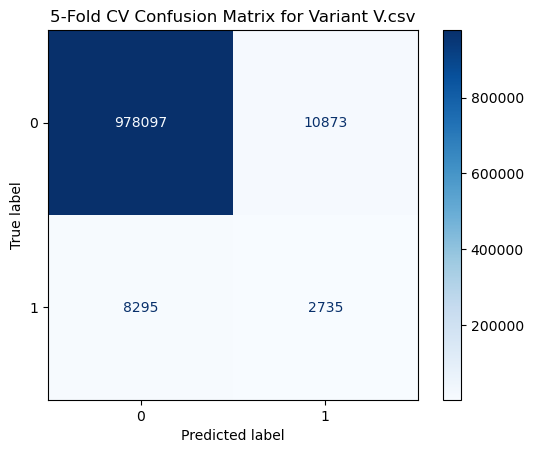

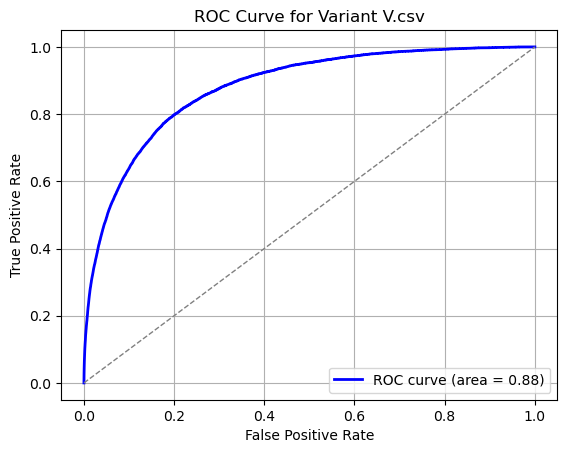

In [8]:
# Loop through each dataset and do the following:
# Preprocess the Data
# Then, fit the dataset and obtain its metrics dataframe
# Store the metrics dictionary in a list, then delete the loaded dataset from memory
# Plot Confusion Matrix
# Plot ROC Curve with AUC
# Delete df to save memory
# Repeat for each dataset
for dataset in data:
    # Load in and Preprocess Data
    print(f"Results for {dataset}")
    df = preprocess_data(dataset)
    
    # Train Model, Predict Results, and Obtain Performance Metrics
    metrics, y_test, y_pred, y_pred_proba, classes = train_categorical_nb_kfold(df, k=5, test_size=0.25, alpha=1.0)
    
    # Convert metrics to dataframe, and then append to results
    # Do this since DataFrame.append is getting depricated
    tmp_metrics = {'dataset': dataset, **metrics}
    tmp_metrics = pd.DataFrame([tmp_metrics])
    results_df = pd.concat([results_df, tmp_metrics], ignore_index=True)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title(f"5-Fold CV Confusion Matrix for {dataset}")
    plt.show()
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Delete df from memory to help with memory costs
    del df

In [9]:
# Display results of all Important Metrics
results_df.head(n=10)

,dataset,accuracy,precision,f1_score,recall,auc
0,Base.csv,0.973552,0.144463,0.191393,0.283616,0.862179
1,Variant I.csv,0.977786,0.154074,0.183147,0.225768,0.849929
2,Variant II.csv,0.973462,0.144572,0.192050,0.285973,0.870664
3,Variant III.csv,0.981774,0.223769,0.242336,0.264279,0.895647
4,Variant IV.csv,0.974465,0.146730,0.190803,0.272801,0.868332
5,Variant V.csv,0.980832,0.200879,0.221943,0.247960,0.879563


# Test effects of Train Test size on Data

In [10]:
# Define train and alpha values to test
# Alpha is scaled by the amount of fradu cases in train set
# alpha = alpha_pct * # of true fraud values in train set
train_splits = list(np.arange(0.05,1.0,0.05))
alpha_pcts = list(np.arange(0.01,0.21,0.01))
alphas_vals = []

In [11]:
# Collect results to observe train size vs accuracy and precision
all_results_train_size = {
    'dataset': [],
    'results': []
}

for dataset in data:
    results_train_size = {
    'train_size': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
    }
    
    # Load, Preprocess, train, and predict
    df = preprocess_data(dataset)
    results = train_categorical_nb(df, train_sizes=train_splits, mode='train_size', constant_alpha=1.0)
    
    # Store in temp results
    results_train_size['train_size'].extend(results['train_size'])
    results_train_size['accuracy'].extend(results['accuracy'])
    results_train_size['precision'].extend(results['precision'])
    results_train_size['recall'].extend(results['recall'])
    results_train_size['f1_score'].extend(results['f1_score'])
    
    # Add temp results to all_storage
    all_results_train_size['dataset'].append(dataset)
    all_results_train_size['results'].append(results_train_size)
    
    # Delete df to help with memory contraints
    del df
    
# Get all accuracy and precision values for min, max evaluation
train_size_accuracy_values = np.concatenate([dataset_results['accuracy'] for dataset_results in all_results_train_size['results']])
train_size_precision_values = np.concatenate([dataset_results['precision'] for dataset_results in all_results_train_size['results']])
train_size_recall_values = np.concatenate([dataset_results['recall'] for dataset_results in all_results_train_size['results']])


# Define y_lim for precision and accuracy graphs
acc_ylim = (np.min(train_size_accuracy_values) - 0.05, 0.99)
prec_ylim = (np.min(train_size_precision_values) - 0.05, np.max(train_size_precision_values))
rec_ylim = (np.min(train_size_recall_values) - 0.05, np.max(train_size_recall_values))

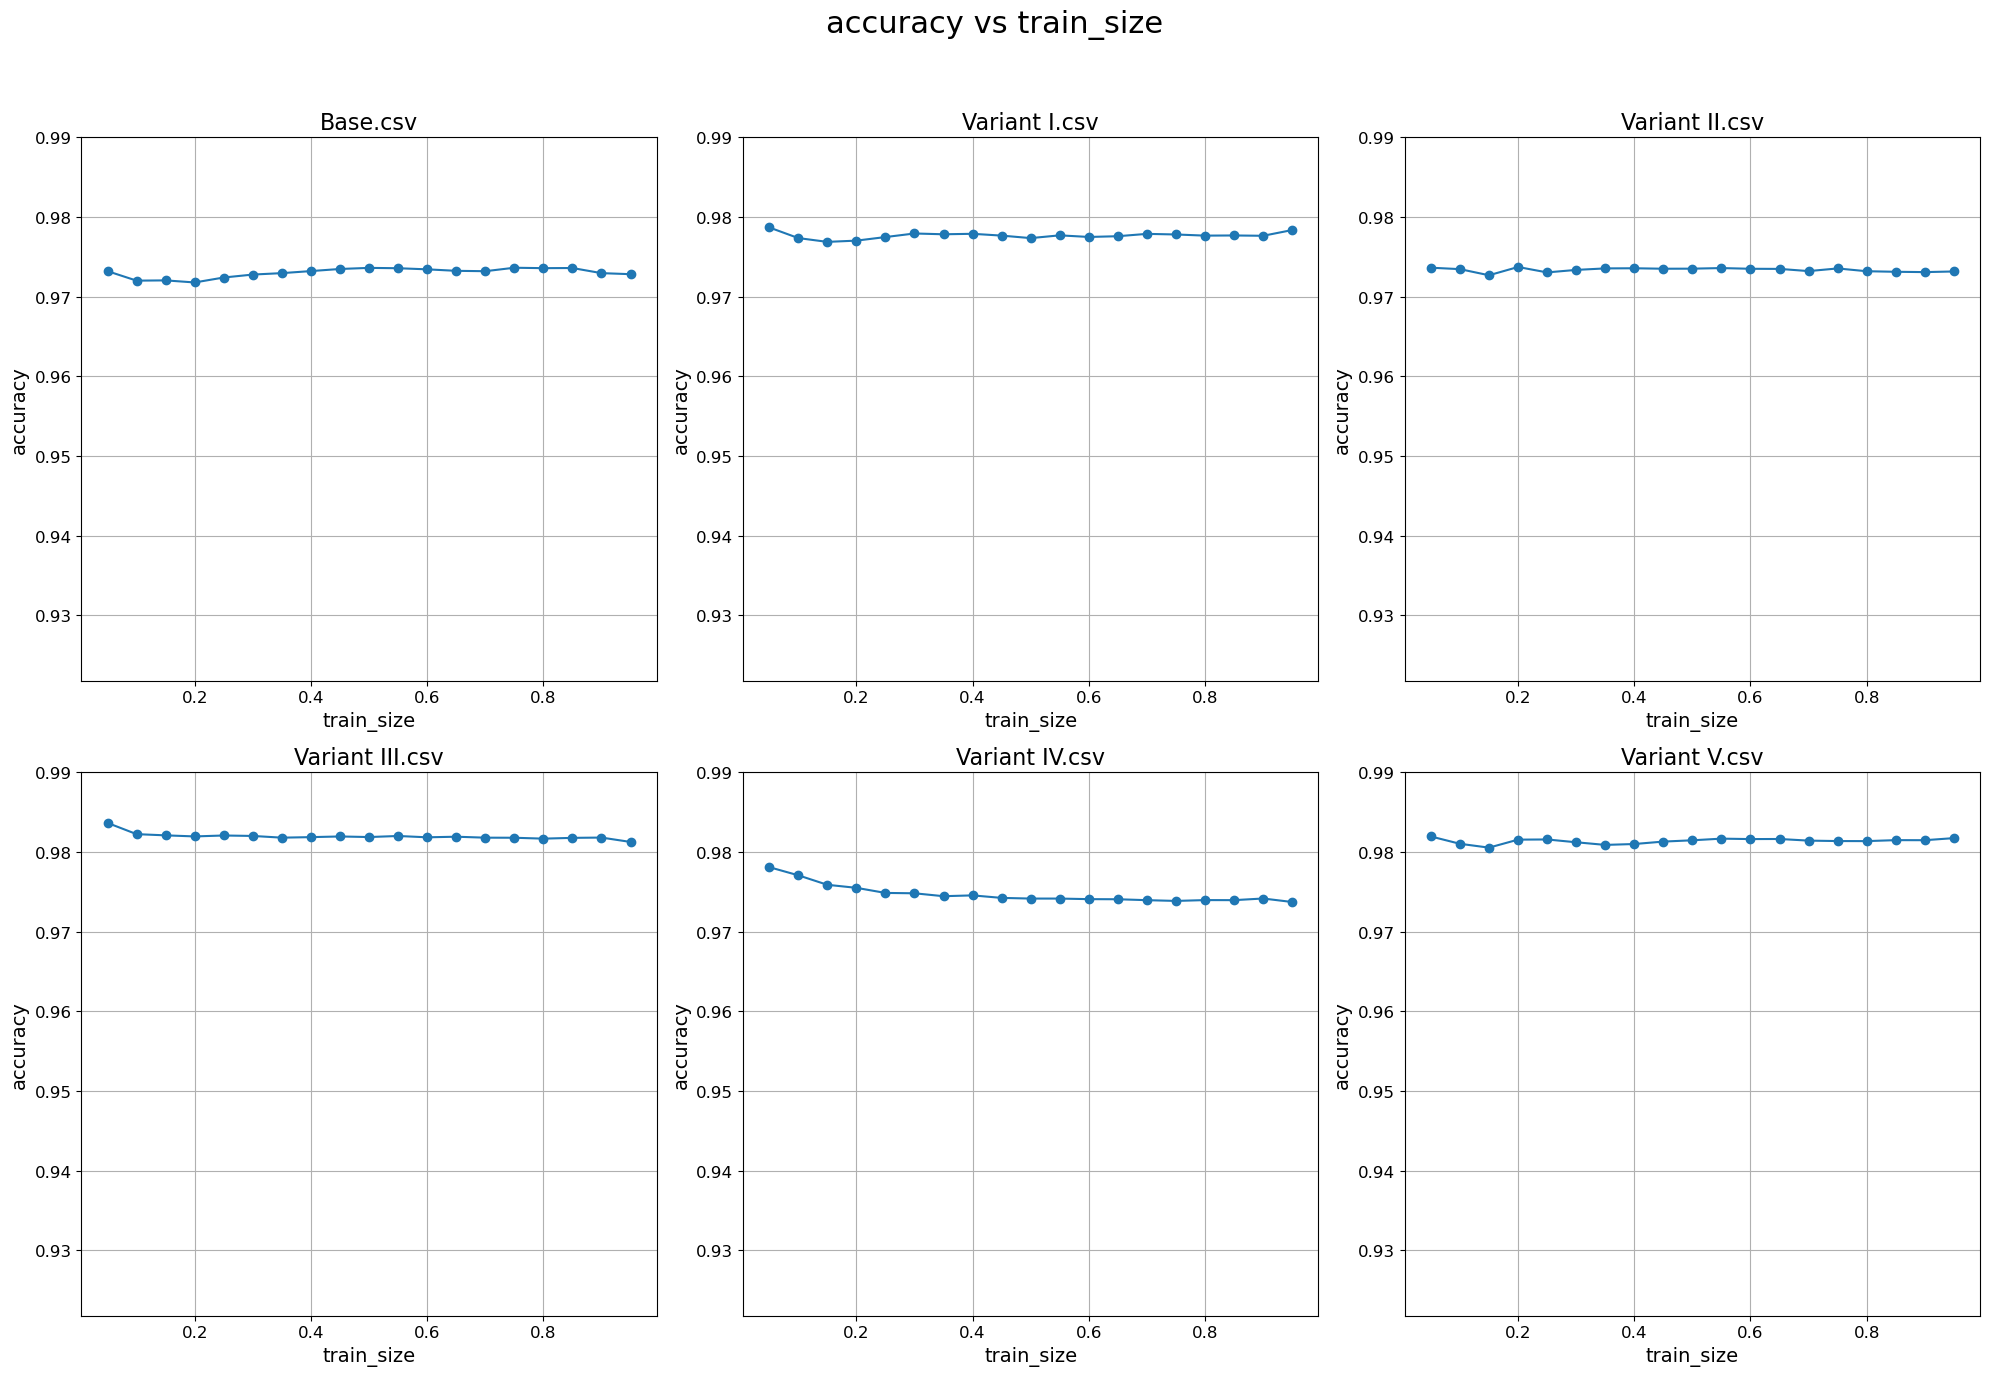

In [12]:
# Plot Accuracy vs Train Size
plot_metric_grids(all_results_train_size, data, metric='accuracy', x_param='train_size',
                  y_lim=acc_ylim)

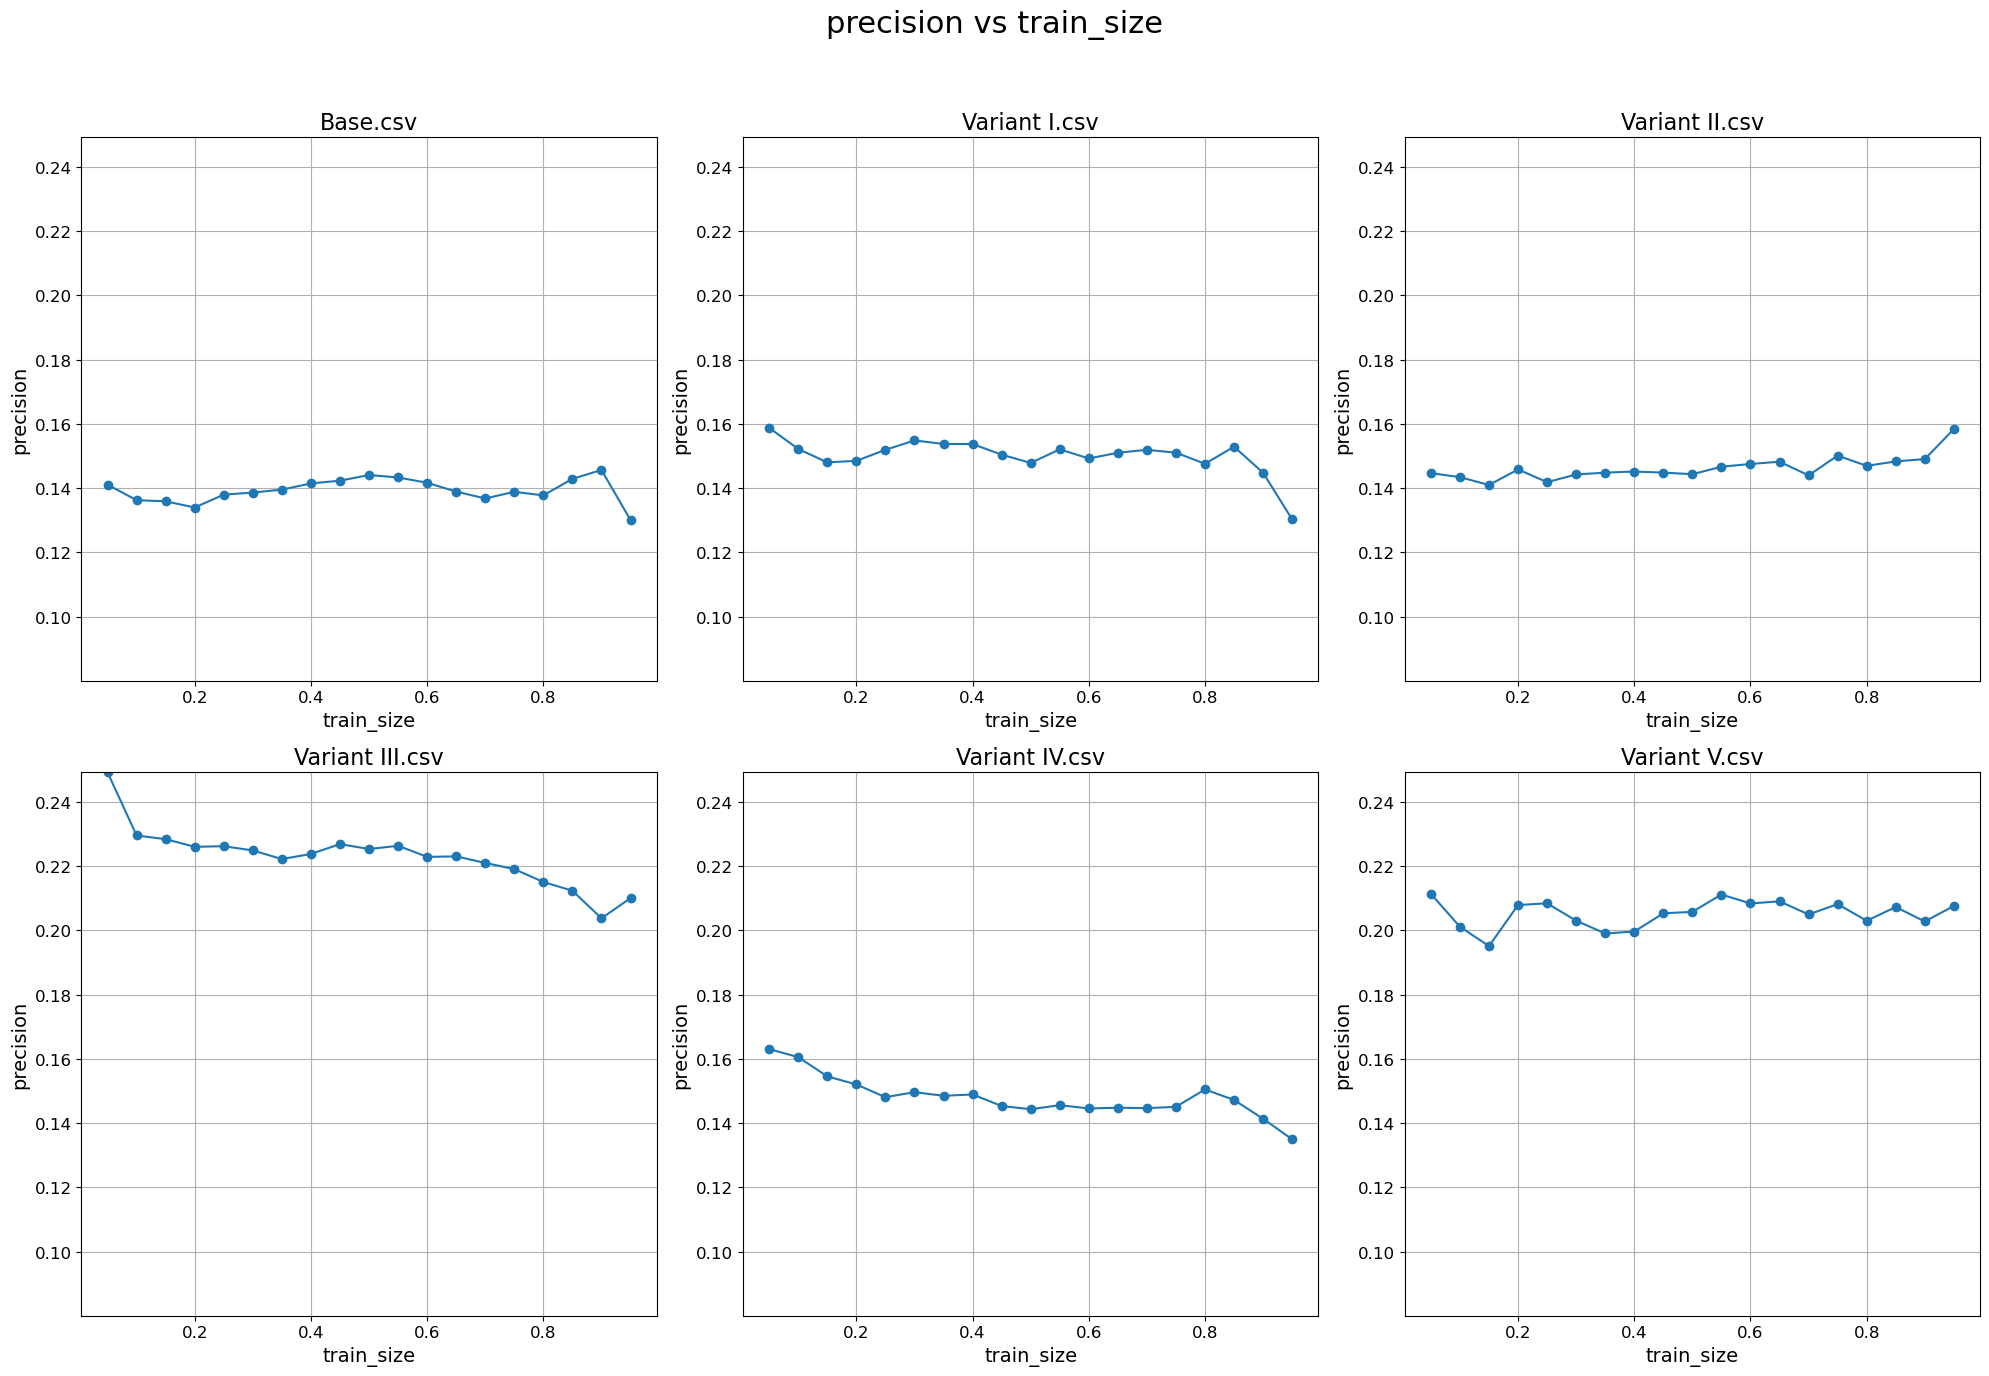

In [13]:
# Plot Precision vs Train Size
plot_metric_grids(all_results_train_size, data, metric='precision', x_param='train_size',
                 y_lim=prec_ylim)

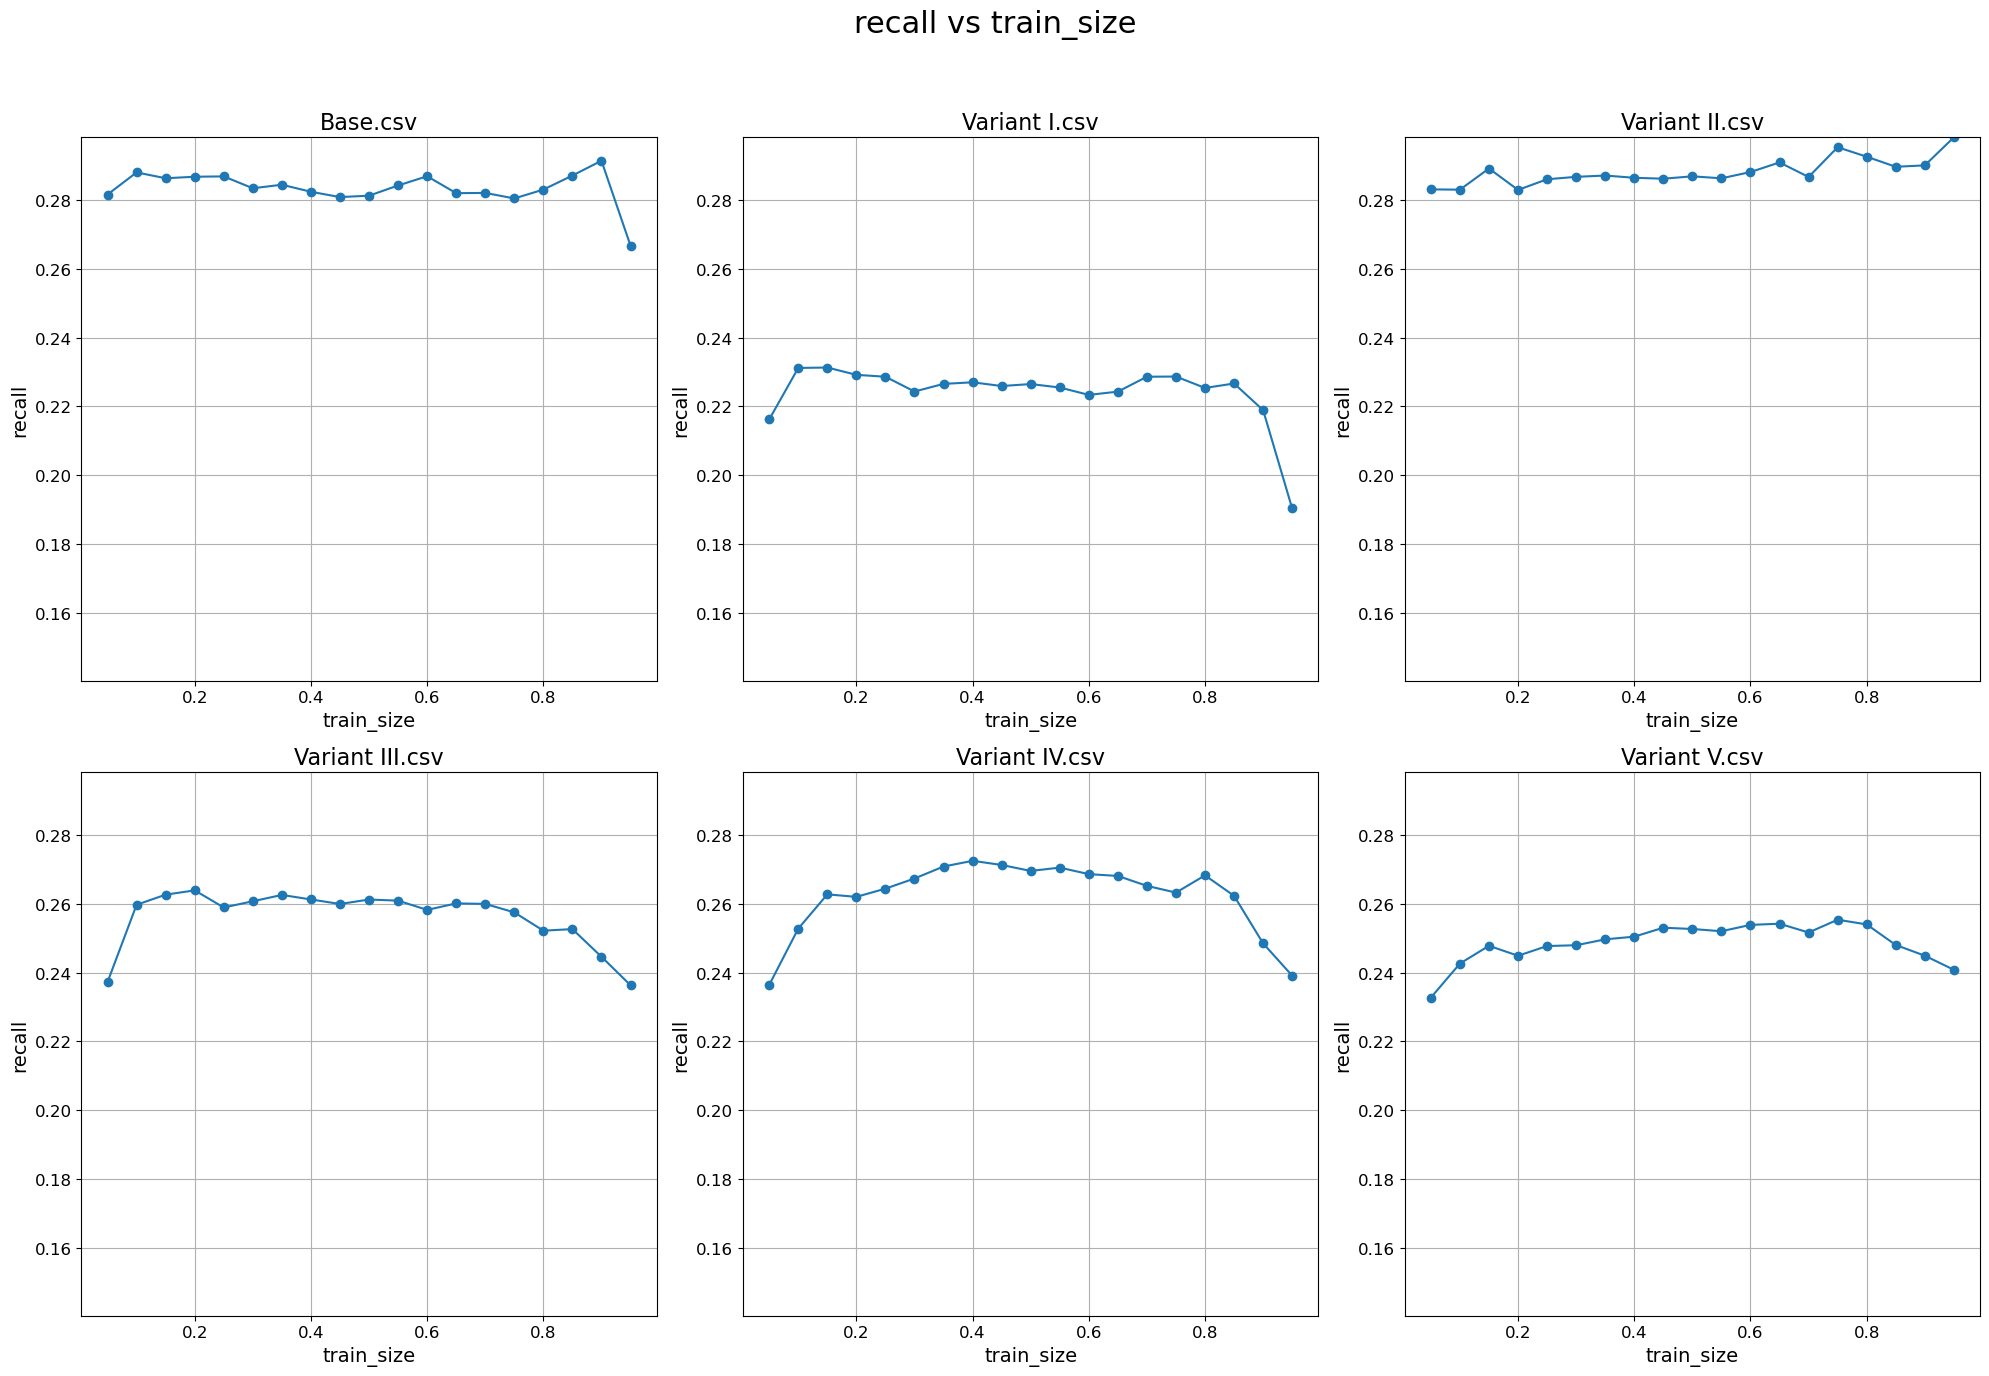

In [14]:
# Plot Recall vs Train Size
plot_metric_grids(all_results_train_size, data, metric='recall', x_param='train_size',
                  y_lim=rec_ylim)

# Test effects of Alpha Smoothing Parameter on Model Performance

In [15]:
# Initialize double dictionary to store all results
all_results_alpha = {
    'dataset': [],
    'results': []
}

for dataset in data:
    # Process each dataset for testing afect of alpha on accuracy, precision
    results_alpha = {
        'alpha': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
    # Load, Preproccess, Train, and Predict for all datasets
    df = preprocess_data(dataset)
    results = train_categorical_nb(df, alpha_pcts=alpha_pcts, mode='alpha', constant_train_size=0.75)
    
    # Store Results in temp dictionary
    results_alpha['alpha'].extend(results['alpha'])
    results_alpha['accuracy'].extend(results['accuracy'])
    results_alpha['precision'].extend(results['precision'])
    results_alpha['recall'].extend(results['recall'])
    results_alpha['f1_score'].extend(results['f1_score'])
    
    # Add temp dictionary to all storage
    all_results_alpha['dataset'].append(dataset)
    all_results_alpha['results'].append(results_alpha)
    
    # Delete df to help with memory costs
    del df
    
# Get all accuracy and precision values for min, max evaluation
alpha_accuracy_values = np.concatenate([dataset_results['accuracy'] for dataset_results in all_results_alpha['results']])
alpha_precision_values = np.concatenate([dataset_results['precision'] for dataset_results in all_results_alpha['results']])
alpha_recall_values = np.concatenate([dataset_results['recall'] for dataset_results in all_results_alpha['results']])

# Set y limits for alpha graphs based on results returned 
acc_ylim = (np.min(alpha_accuracy_values) - 0.05, 0.99)
prec_ylim = (np.min(alpha_precision_values) - 0.05, np.max(alpha_precision_values))
rec_ylim = (np.min(alpha_recall_values) - 0.05, np.max(alpha_recall_values))

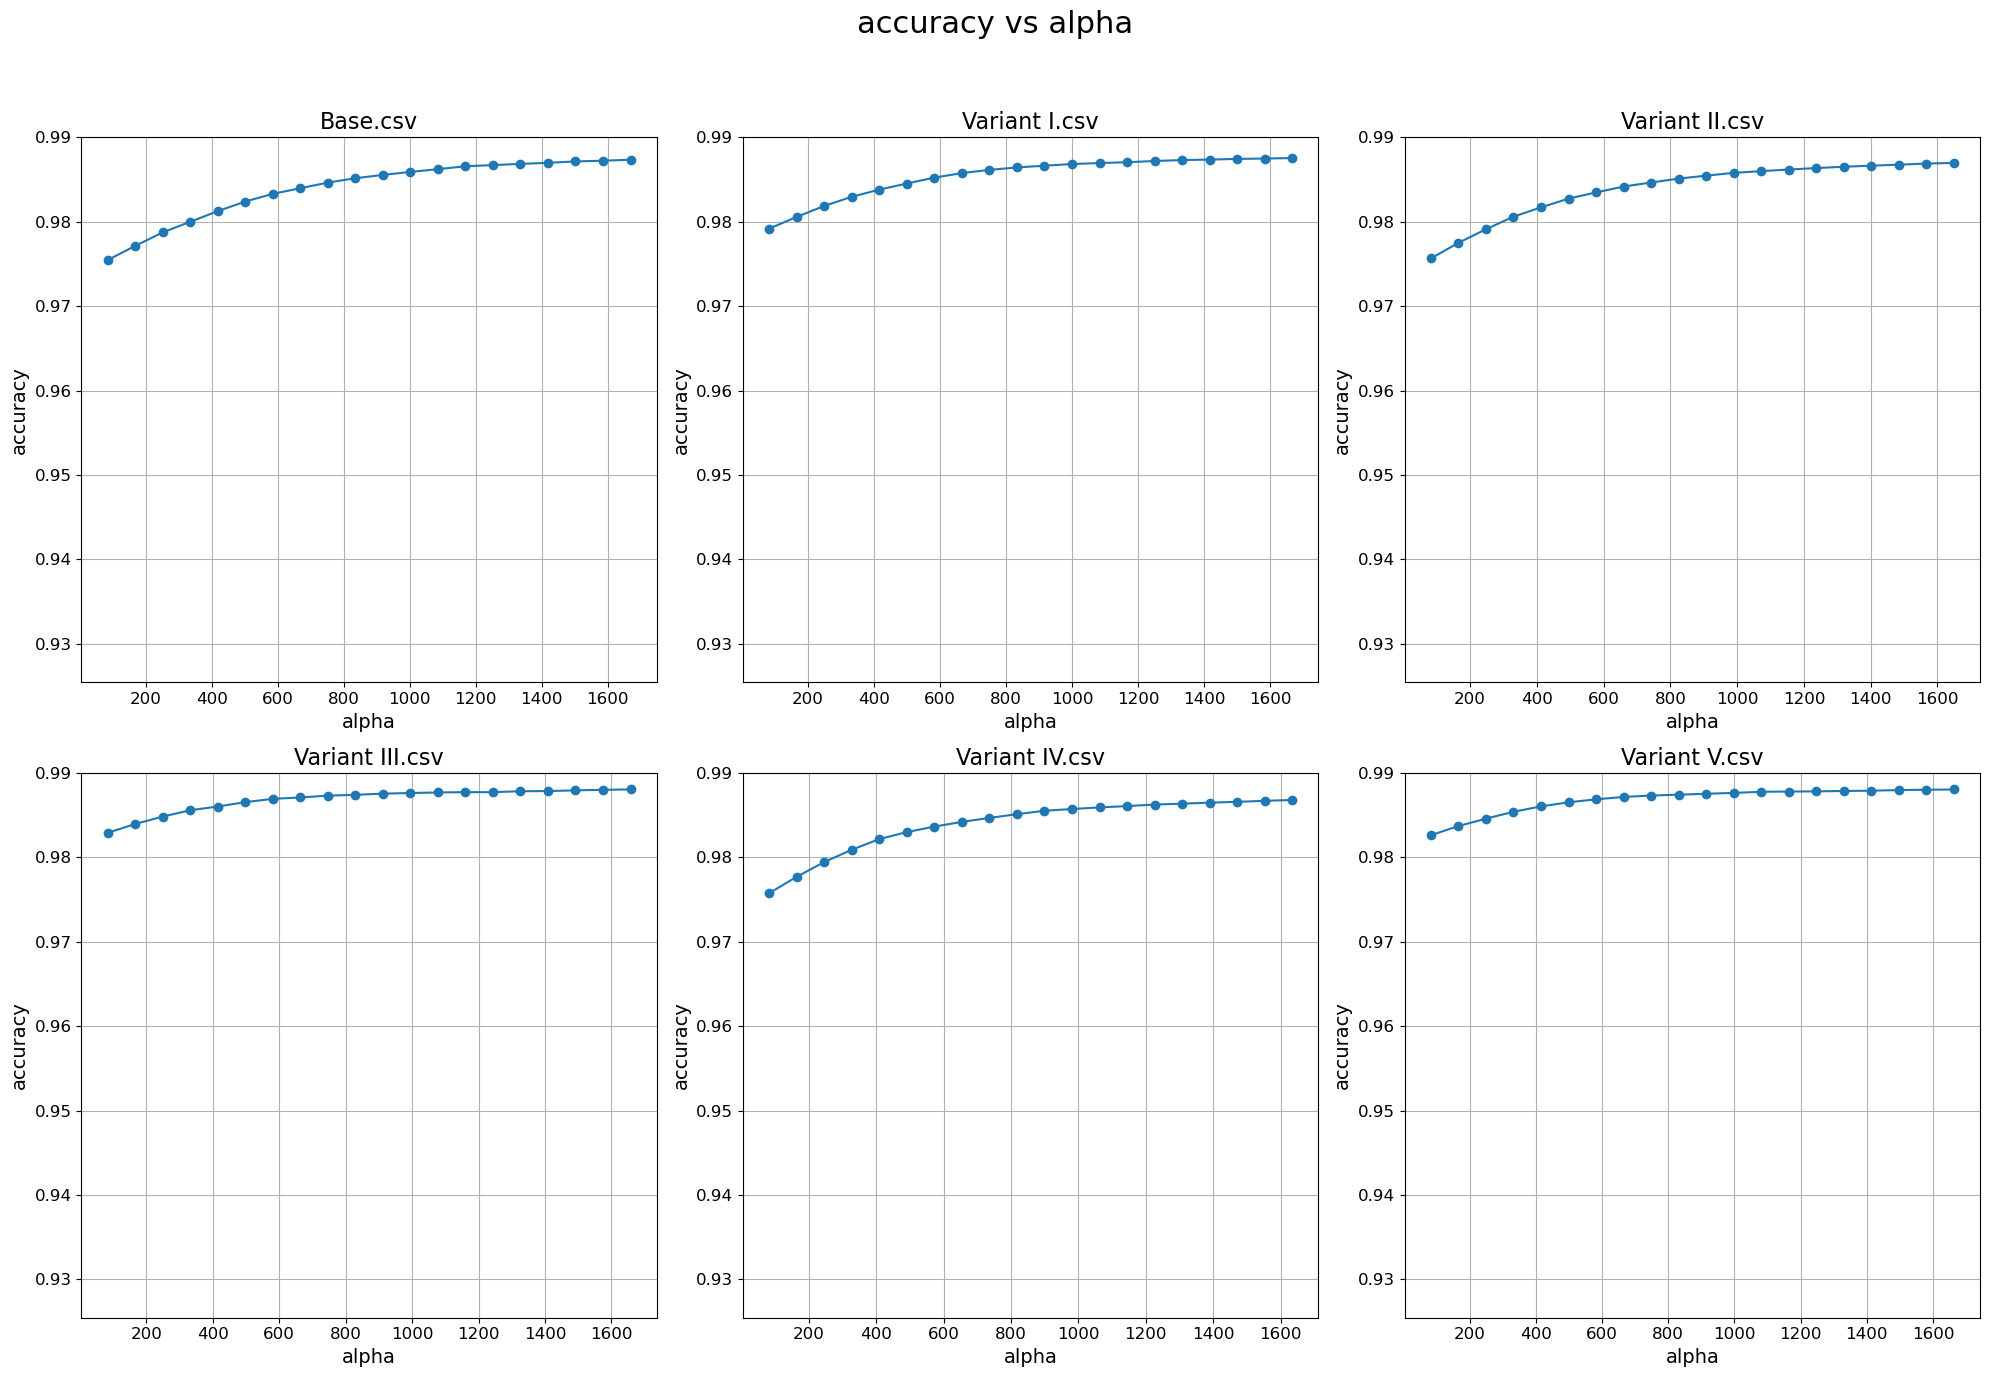

In [16]:
# Plot Accuracy vs Alpha
plot_metric_grids(all_results_alpha, data, metric='accuracy', x_param='alpha', y_lim=acc_ylim)

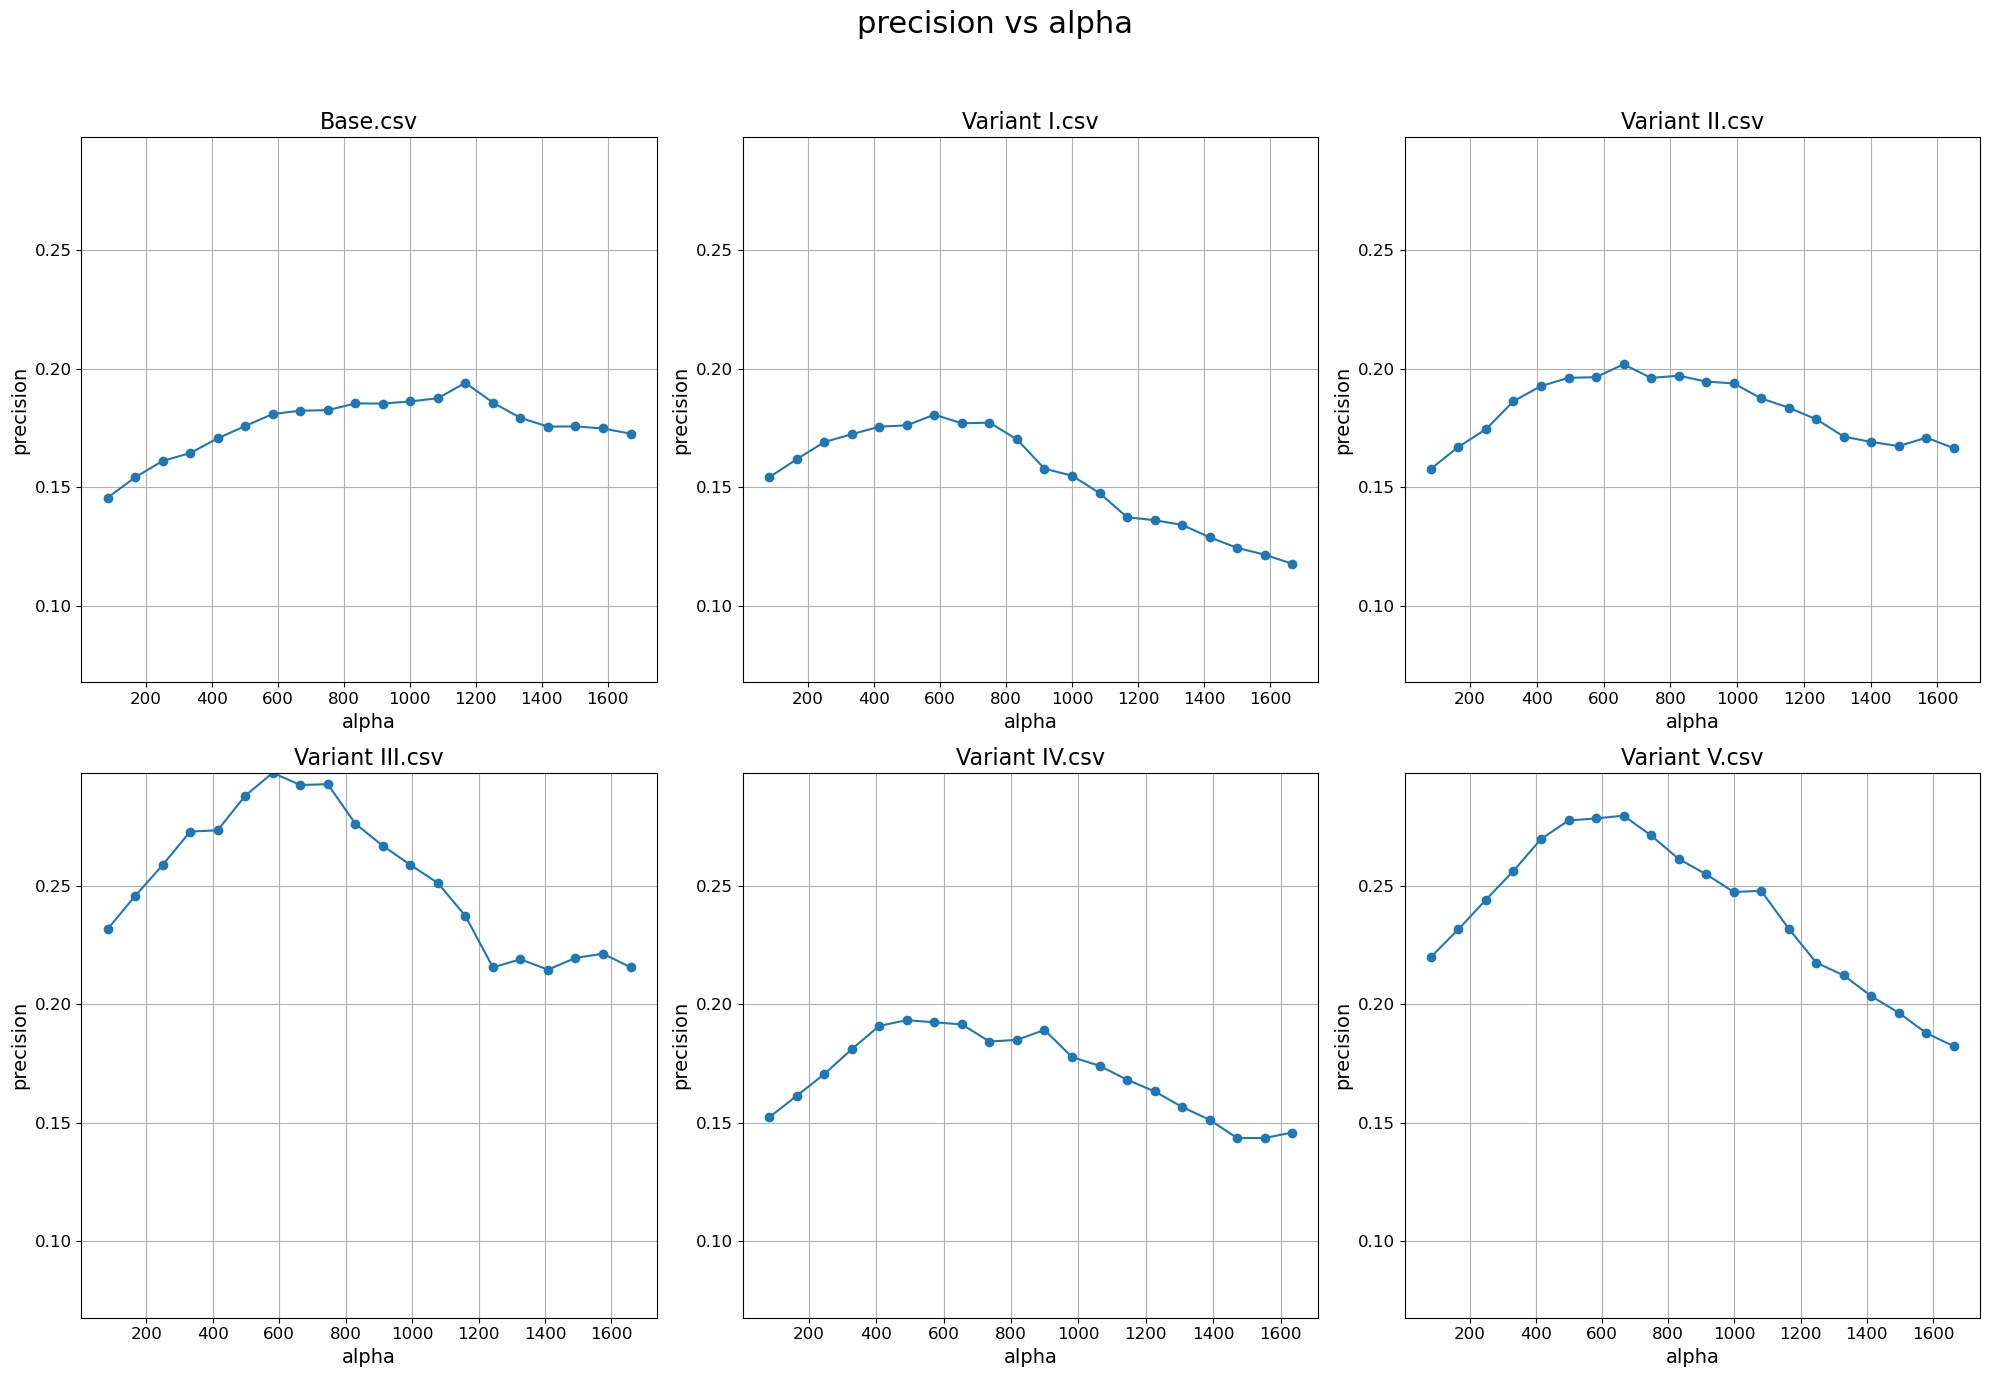

In [17]:
# Plot Precision vs Alpha
plot_metric_grids(all_results_alpha, data, metric='precision', x_param='alpha', y_lim=prec_ylim)

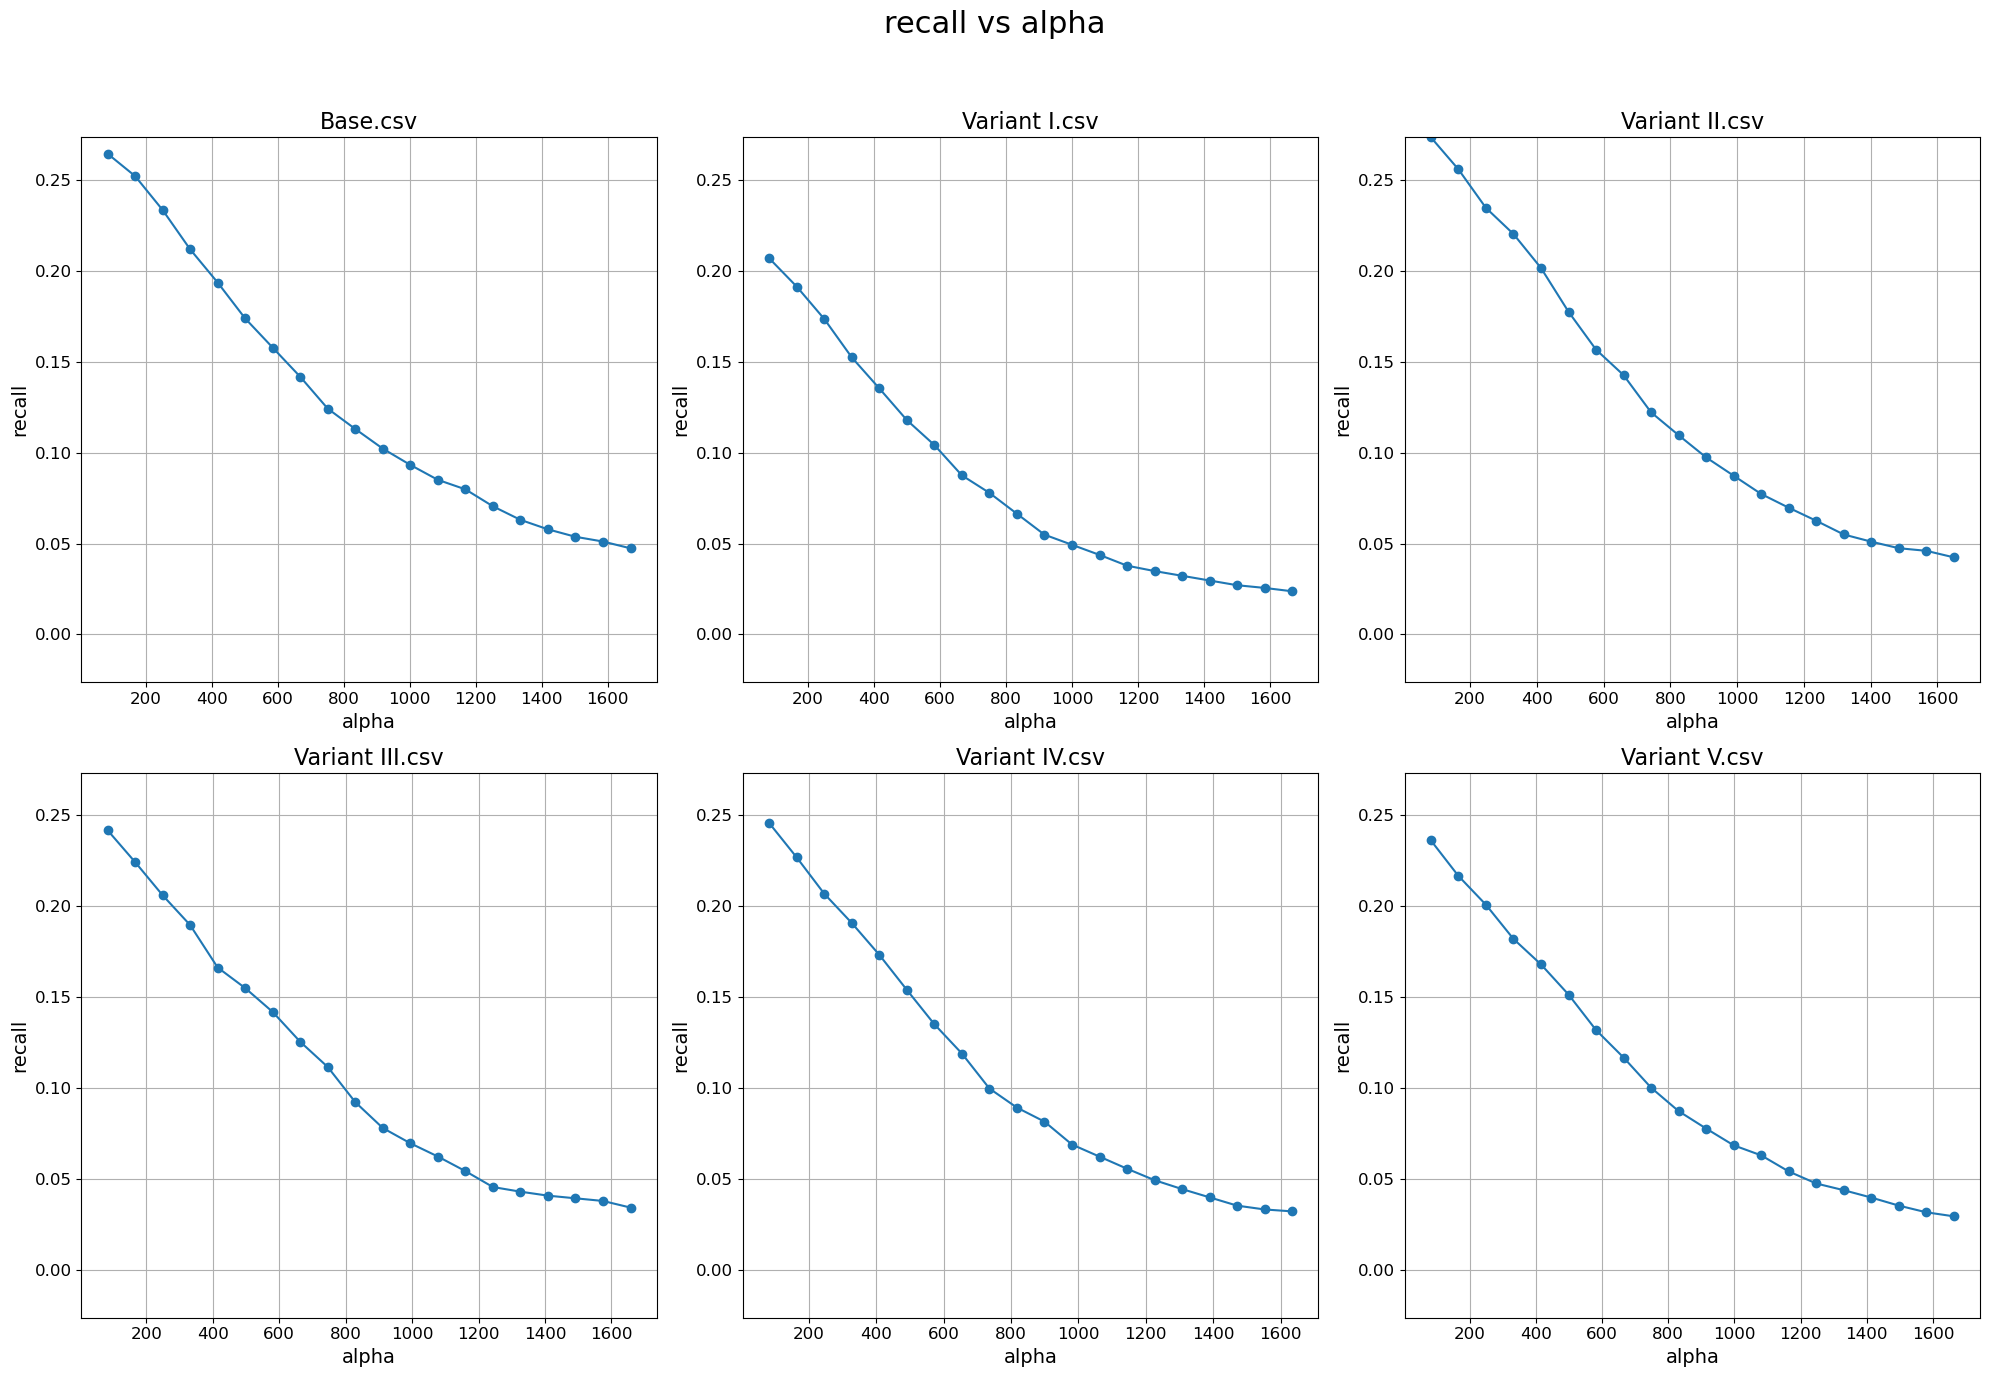

In [18]:
# Plot Recall vs Alpha
plot_metric_grids(all_results_alpha, data, metric='recall', x_param='alpha', y_lim=rec_ylim)